In [1]:
import cv2
import errno
import glob
from IPython.display import display
from IPython.html.widgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time

/home/baxter/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
package_dirname = '/home/baxter/ros_ws/src/baxter_pick_and_place/'
base_dirname = os.path.join(package_dirname, 'data', 'sdd')
negative_dirname = os.path.join(base_dirname, 'negative')
positive_dirname = os.path.join(base_dirname, 'positive')
print negative_dirname
print positive_dirname

/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/negative
/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/positive


## Negative samples

In [3]:
negative_samples = glob.glob(os.path.join(negative_dirname, '*.jpg'))
print "Found %i negative (background) samples." % len(negative_samples)

Found 75 negative (background) samples.


In [4]:
negative_filename = os.path.abspath(os.path.join(negative_dirname, '..', 
                                                 'bg.txt'))
with open(negative_filename, 'w') as fp:
    for ns in negative_samples:
        fp.write("%s\n" % ns)
print "Wrote %i negative samples to %s." % (len(negative_samples), 
                                            negative_filename)

Wrote 75 negative samples to /home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/bg.txt.


## Positive samples

In [5]:
positive_samples = glob.glob(os.path.join(positive_dirname, 'bin*', '*.jpg'))
positive_samples = [positive_samples[idx] for idx in range(len(positive_samples)) 
                    if 'roi' not in positive_samples[idx]]
print "Found %i positive samples." % len(positive_samples)

Found 210 positive samples.


(375, 620)


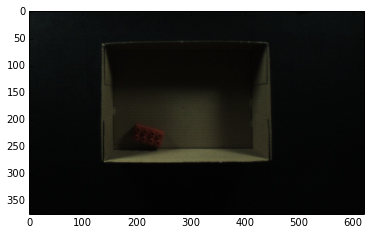

In [6]:
idx = np.random.randint(len(positive_samples))
sample = cv2.imread(positive_samples[idx])
print sample.shape[:-1]
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))

In [7]:
def segment_bin(img_name, th=200, ff_fixed_range=True, ff_connect=4, ff_low=50, ff_high=255, 
                c_low=50, c_high=270, verbose=False):
    """ Segment bin to put objects into.
    :param img: an image
    :param th: theshold for binary threshold
    :param c_low: lower bound for Canny threshold
    :param c_high: upper bound for Canny threshold
    :return: rotated and upright enclosing box (((cx, cy), (w, h), alpha), corners), (x, y, w, h)
    """
    fig = plt.figure(figsize=(16, 20))
    
    img = cv2.imread(img_name)
    if img is None:
        raise Exception("Loading '%s' failed!" % img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.subplot(421)
    plt.imshow(gray, cmap='gray')
    
    # do Histogram equalization and theshold image
    equ = cv2.equalizeHist(gray)
    plt.subplot(422)
    plt.imshow(equ, cmap='gray')
    _, thresh = cv2.threshold(equ, th, 255, cv2.THRESH_BINARY)
    plt.subplot(423)
    plt.imshow(thresh, cmap='gray')
    
    # widen edges and compute morphological gradient (outline)
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=1)
    outline = cv2.morphologyEx(opening, cv2.MORPH_GRADIENT, kernel, iterations=2)
    plt.subplot(424)
    plt.imshow(outline, cmap='gray')

    # flood fill image
    h, w = thresh.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    mask[1:-1, 1:-1] = outline
    seed_pt = (mask.shape[0], 0)
    flooded = gray.copy()
    flags = ff_connect
    if ff_fixed_range:
        flags |= cv2.FLOODFILL_FIXED_RANGE
    cv2.floodFill(flooded, mask, seed_pt, (255, 255, 255), (ff_low,)*3, (ff_high,)*3, flags)
    plt.subplot(425)
    plt.imshow(flooded, cmap='gray')

    # do Canny edge extraction and widen edges
    canny = cv2.Canny(flooded, c_low, c_high, apertureSize=3)
    kernel = np.ones((3, 3), np.uint8)
    canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel, iterations=1)
    plt.subplot(426)
    plt.imshow(canny, cmap='gray')
    
    # find contours, largest contour equals our bin
    sample = img.copy()
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0.0
    contour = None
    for c in contours:
        area = cv2.contourArea(c)
        if 10000 < area < 100000:
            if area > max_area:
                max_area = area
                contour = c
                
    if contour is None:
        if not verbose:
            plt.close()
        raise ValueError('ERROR-segment_bin-No contour found!' +
                         ' Please adjust Canny thresholds.')
        
    # visualize bin contour
    # rotated rectangle
    rrect = cv2.minAreaRect(contour)
    box = cv2.cv.BoxPoints(rrect)
    b = np.int0(box)
    cv2.drawContours(sample, [b], 0, (0, 255, 0), 2)
    cv2.circle(sample, (int(rrect[0][0]), int(rrect[0][1])), 3, (0, 255, 0), 2)
    
    # upright rectangle
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.circle(img, (x+w/2, y+h/2), 3, (255, 0, 0), 2)

    plt.subplot(427)
    plt.imshow(sample)
    plt.subplot(428)
    plt.imshow(img)
    plt.savefig(os.path.splitext(img_name)[0] + '_roi.jpg', bbox_inches='tight')
    if not verbose:
        plt.close()
    return (rrect, box), (x, y, w, h)

In [8]:
def silent_remove(filename):
    try:
        os.remove(filename)
    except OSError as e:
        if e.errno != errno.ENOENT:
            raise

In [ ]:
obj = 'bin'

positive_filename = os.path.abspath(os.path.join(positive_dirname, '..', 
                                                 obj+'_info.dat'))
silent_remove(positive_filename)
failed_filename = os.path.abspath(os.path.join(positive_dirname, '..', 
                                               obj+'_info_fail.dat'))
silent_remove(failed_filename)

th = 210
c_low = 110
c_high = 170

start = time.time()
pos = 0
fail = 0
f = FloatProgress(min=0, max=len(positive_samples))
f.description = "Processing base '%s'-images" % obj
display(f)
for sample in positive_samples:
    try:
        _, rect = segment_bin(sample, th=th, c_low=c_low, c_high=c_high)
        with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (sample.split(base_dirname)[-1], 1, rect[0], rect[1], rect[2], rect[3]))
        pos += 1
    except ValueError:
        with open(failed_filename, 'a') as fp:
            fp.write('%s\n' % sample)
        fail += 1
    f.value = pos+fail
    
print "Wrote %i positive '%s'-samples in %.2fs to %s." % (pos, obj, time.time()-start, positive_filename)
print "(%i/%i samples failed.)" % (fail, len(positive_samples))

In [29]:
with open(failed_filename, 'r') as fp:
    failed_samples = fp.read().splitlines()

/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/positive/bin+extra_mints/654383248284.jpg


((((182.99996948242188, 187.49998474121094),
   (321.99993896484375, 248.99996948242188),
   0.0),
  ((22.0, 311.9999694824219),
   (22.0, 63.0),
   (343.99993896484375, 63.0),
   (343.99993896484375, 311.9999694824219))),
 (22, 63, 323, 250))

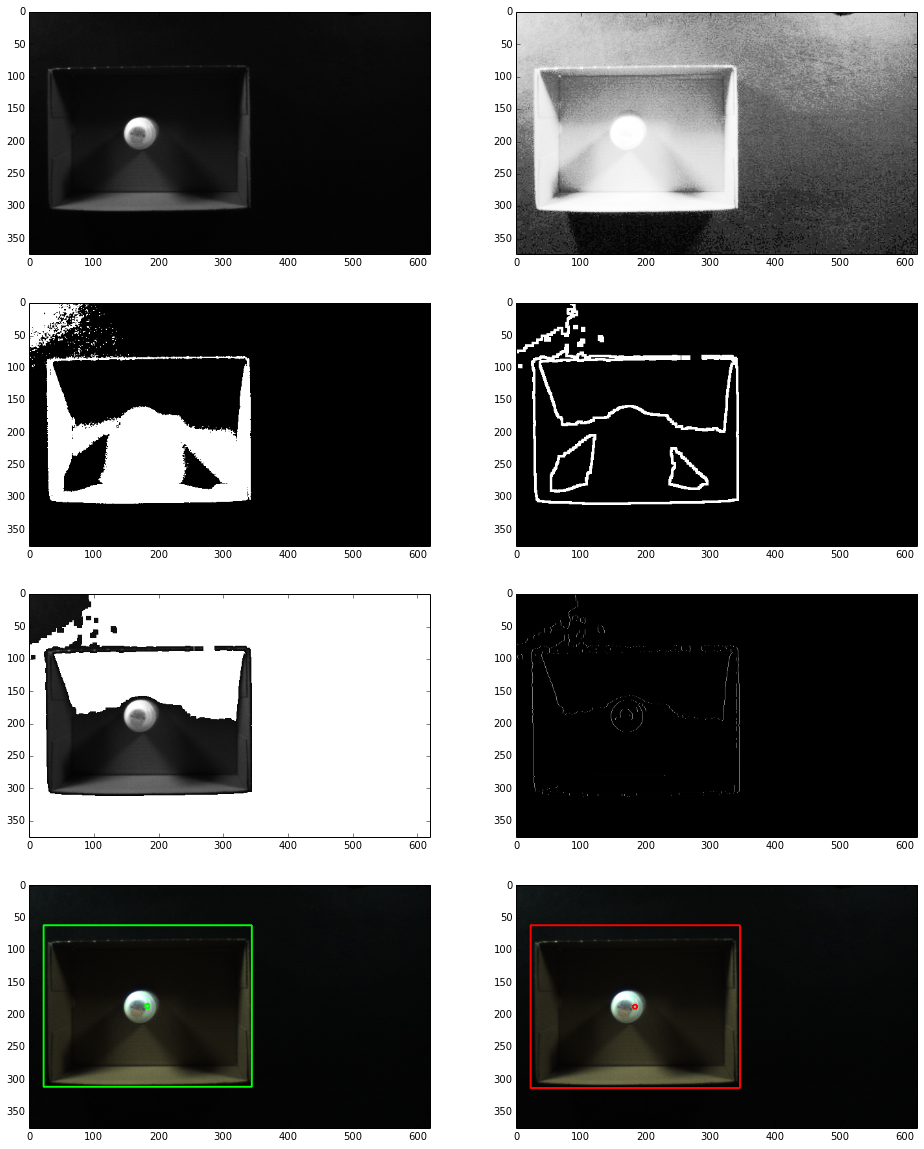

In [71]:
idx = 40

th = 210
c_low = 110
c_high = 170

sample = failed_samples[idx]
print sample
segment_bin(sample, th=th, c_low=c_low, c_high=c_high, verbose=True)